# Imports

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, norm, chi2
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

## Import Functions

In [2]:
from src.K_Means_optimisation_GenePy import KM_opt, KM_opt_stabl, KM, KM_random, compute_ari_matrix, KM_RF, merge_phen_genepy, compute_clustering_metrics
from src.cluster_enrichment_analysis import analyze_cluster_deviations
from src.Plotting import plotk, plot_ari_heatmap, plot_clustering_metrics

## Import SPARC IBD CADD15 GenePy Matrix

In [27]:
#Import SPARC IBD CADD15 GenePy matrix
SPARC_IBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/IBD Plexus/GenePy/sparc_ibd_ccds_CADD15_merged_filt_mmscaled.matrix")

#Set samid as index
SPARC_IBD_CADD15_GenePy = SPARC_IBD_CADD15_GenePy.set_index("samid")

## Import Southampton IBD CADD15 GenePy Matrix

In [28]:
# Import Soton Local IBD CADD15 GenePy matrix
#dtype_dict = {"Gender": "object", "Age at diagnosis": "float64",
#              'Diagnosis': "object", "Stricturing": "object", "Fistulating": "object",
#              'Granuloma': "object", 'IBD Surgery': 'int64', 'IBD phenotype': 'object'}

SotonIBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Soton Local IBD/GenePy/jcmar24_IBD_CADD15_merged_filt_mmscaled.matrix"
                                       #,dtype=dtype_dict
                                       )

#Set samid as index
SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy.set_index("Samid")

#SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy[SotonIBD_CADD15_GenePy['Diagnosis'] != "NOT_IBD"]

## Import Mt Sinai IBD CADD15 GenePy Matrix

In [3]:
MSCCR_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Mt Sinai/GenePy/jcJul25_Sinai_ccds_merged_subset_CADD15.mmscaled.matrix")

#Set samid as index
MSCCR_CADD15_GenePy = MSCCR_CADD15_GenePy.set_index("sample_ids")

MSCCR_IBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Mt Sinai/GenePy/jcJul25_Sinai_ccds_IBD_merged_subset_CADD15.mmscaled.matrix")
MSCCR_IBD_CADD15_GenePy = MSCCR_IBD_CADD15_GenePy.set_index("sample_ids")

## Import Gene Lists

In [76]:
NOD_sig_genes9 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes9.txt")
NOD_sig_genes12 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes12.txt")
NOD_sig_genes13 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes13.txt")
NOD_sig_genes43 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes43.txt")
JAK_STAT_sig_genes_30 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/JAK_STAT_sig_genes30.txt")
IL10_sig_genes_13 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes13.txt")
IL10_sig_genes_49 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes49.txt")
IL23_sig_genes_20 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL23_genes20.txt")
Th17_sig_genes_11 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/Th17_genes11.txt") #All of these genes are in the list of 20 IL-23 signalling genes
NADPH_genes_12 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes12.txt")
NADPH_genes_36 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes36.txt")

In [ ]:
NOD2_gene = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] == 'NOD2',:]
NOD_sig_genes9_noNOD2 = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] != 'NOD2',:]

### IBD Consensus Pathways

In [ ]:
IBD_consensus_paths = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Progression Reviews/Confirmation Progression Review/Supp material/Consensus IBD pathway genes.txt")
IBD_union_genes = IBD_consensus_paths.loc[(IBD_consensus_paths['NOD signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-10 signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-23 signalling consensus 2'] == 1) |
(IBD_consensus_paths['Th17 differentiation consensus 2']) | (IBD_consensus_paths['JAK-STAT consensus 2'] == 1) | (IBD_consensus_paths['NADPH oxidases consensus 2'] == 1),:]
IBD_union_genes = IBD_union_genes.iloc[:,list(range(0,4)) + [11] + [13] + [15] +[17] + [19] + [21]]
IBD_union_genes.loc[IBD_union_genes['Gene name'] == 'NOXO1', 'Gene stable ID'] = "ENSG00000196408"

In [ ]:
IBD_union_genes['GenePy gene'] = IBD_union_genes['Gene stable ID'] + "_" + IBD_union_genes['Gene name'] + "_CADD15_matrix"
IBD_union_genes_sparc = IBD_union_genes.loc[:,['Gene stable ID', 'Gene name', 'GenePy gene']]

In [ ]:
IBD_union_genes_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IBD_union_genes.txt", index=False, sep='\t')

# SPARC IBD

## NOD2

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='SPARC')

In [ ]:
plotk(results_df, [18,37, 47])

In [ ]:
#k = 18
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD2_gene, 18)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#Get list of patients with no NOD2 signal
SPARC_GenePy_0_NOD2_samid = km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['Samid']
SPARC_GenePy_0_NOD2_samid

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_NOD2_18C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2'] #.keys()

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['ENSG00000167207_NOD2_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 3) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

## 9 NOD Signalling Genes

In [ ]:
#Optimise k based on silhouette score and DBI
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='SPARC')

In [ ]:
results_df

In [ ]:
plotk(results_df, [12,21, 34])

In [ ]:
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, "SPARC", n_iter=100)
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", sep="\t", index=False)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", index_col=None)

In [ ]:
metrics_df

In [ ]:
plot_clustering_metrics(metrics_df, vlines=[12, 23])

### K = 12

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 12)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_9F_12C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
#km_out_sparc.value_counts()
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 23

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 23)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_9F_23C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts()

In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values("Importance", ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
#results_df['Diagnosis']['overall_p_value'] #.keys()
#type(results_df['Diagnosis']['overall_p_value'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 35

In [ ]:
#For k = 21, silhouette score is 0.5126 and the DBI score is 0.8283
#k = 15; silhouette score = 0.398559; DBI = 0.923939
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 35)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_9F_35C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp_sparc[feat_imp_sparc['Feature'] == "ENSG00000167207_NOD2_CADD15_matrix"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 1]['ENSG00000106100_NOD1_CADD15_matrix'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy_sparc[km_out_phen_GenePy_sparc['Cluster'] == 3]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy_sparc[(km_out_phen_GenePy_sparc['Cluster'] == 3) & (km_out_phen_GenePy_sparc['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Diagnosis']['p_values_chi2']#.keys()

### K = 21

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
feat_imp[feat_imp['Cluster'] == 7].sort_values(by='Importance', ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']#.keys()

In [ ]:
#Cluster 14 - enriched for CD and depleted for UC
#193 CD/UC patients with NOD2 GenePy within 0.2607 to 0.4545, RIPK2 GenePy =< 0.1756 (192 have a score of 0) and NOD1 within 0 and 0.394107
SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.454504) &
                                             (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.394107)).astype(int)

# SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] <= 0.454504) &
#                                               (SotonIBD_CADD15_GenePy['ENSG00000104312.8_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100.11_NOD1'] <= 0.394107)).astype(int)

In [ ]:
#Cluster 19 is depleted for UC (n = 113)
#NOD2 (47.15%) -> 0.132311-0.406112
#RIPK2 (46.16%) -> 0.175602-0.490679
#NOD1 (2.1369%) -> <= 0.127193
SotonIBD_CADD15_GenePy['cluster 19'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311) &
                                               (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.406112) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679) &
                                              (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.127193)).astype(int)

In [ ]:
#Cluster 4 is depleted for UC
#NOD2 (96.76%) -> >= 0.732
SotonIBD_CADD15_GenePy['cluster 4'] = (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.732).astype(int)

In [ ]:
#Cluster 12 -> 357 patients with NOD2 0 and CHUK 0, RIPK2 0
SotonIBD_CADD15_GenePy['cluster 12'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000213341_CHUK'] == 0)
                                            & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] == 0)).astype(int)

In [ ]:
SotonIBD_CADD15_GenePy.loc[(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679),:].value_counts("ENSG00000104312_RIPK2")

## 43 NOD Signalling Genes

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
results_df

In [ ]:
metrics_df

In [ ]:
plotk(results_df, [9, 29, 43])

In [ ]:
plot_clustering_metrics(metrics_df, vlines=[9, 20, 29, 42])

### K = 9

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 9)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_9C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
X.var()

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 20

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 20)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_20C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
#feat_imp_sparc[(feat_imp_sparc['Importance'] <= 0.60) & (feat_imp_sparc['Importance'] >= 0.10)]
feat_imp_sparc[feat_imp_sparc['Feature'] == 'ENSG00000185386_MAPK11_CADD15_matrix']
#feat_imp_sparc[feat_imp_sparc['Cluster'] == 6]

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 29

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 29)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_29C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
feat_imp_sparc[(feat_imp_sparc['Importance'] <= 0.60) & (feat_imp_sparc['Importance'] >= 0.10)]

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 42

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 42)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_43F_42C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### Other K

In [ ]:
# k = 16
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 16)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
#km_out.value_counts()

In [ ]:
feat_imp = KM_RF(km_out_sparc, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Diagnosis']['corr_p_values_chi2']

In [ ]:
results_df['Crohn s disease phenotype']['corr_p_values_chi2']

In [ ]:
results_df['IBD surgery final']['corr_p_values_chi2']

In [ ]:
#Cluster 1
#NOD2 70.22% -> 0.1323 - 0.3652
#SUGT1 3.96% -> <= 0.2013
#ERBIN 2.67% ->  <= 0.3058
#MAPK12 2.09% -> <= 0.2843
#NOD1 1.75% -> <= 0.2768
#RELA 1.69% -> 0
#BIRC3 1.69% -> 0
#NLRP1 1.43% -> <= 0.2021
#CASP8 1.32% -> <= 0.09
SotonIBD_CADD15_GenePy['Cluster 1'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311468176971) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.365205488832726)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.201280690665366) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.375835188227294)&
                                       (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.276787154268017) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)).astype(int)

In [ ]:
#Cluster 5
#NOD2 46.21% -> 0
#SUGT1 13.83% -> <= 0.007
#ERBIN 5.16% -> <= 0.3254
#MAPK12 4.22% -> <= 0.2843
#NOD1 3.65% -> <= 0.3178
#RELA 3.59% -> 0
#NRLP1 3.15% -> <= 0.2021
#CARD9 2.84% -> 0
#BIRC3 2.31% -> 0
#TAB1 2.12% -> 0
#CARD8 1.77% -> 0
#NLRP7 1.31% -> 0
SotonIBD_CADD15_GenePy['Cluster 5'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.0070120773143289)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.325406754325555)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.317840326123237) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)&(SotonIBD_CADD15_GenePy['ENSG00000187796_CARD9'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0)& (SotonIBD_CADD15_GenePy['ENSG00000100324_TAB1'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000105483_CARD8'] == 0)
                                       ).astype(int)

In [ ]:
#Cluster 13
#NOD2 76.41% -> >= 0.3585
#ERBIN 2.08% -> <= 0.5793
#NOD1 1.88% -> <= 0.5118
#CASP9 1.62% -> <= 0.6922
#NLRP12 1.42% <= 0.4622
#MAPK12 1.37% -> <= 0.44
#RELA 1.17% -> <= 0.4136
#CARD6 1.07% -> <= 0.4563
SotonIBD_CADD15_GenePy['Cluster 13'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.358468103620945) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.579367065203214) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.511821245992663) & (SotonIBD_CADD15_GenePy['ENSG00000132906_CASP9'] <= 0.692219162925112)
                                        & (SotonIBD_CADD15_GenePy['ENSG00000142405_NLRP12'] <= 0.462179899117249)&
                                        (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.442011527819315) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] <= 0.41358255389904) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000132357_CARD6'] <= 0.456358576821125)
                                        ).astype(int)

In [ ]:
cont_table = pd.crosstab(SotonIBD_CADD15_GenePy['Cluster 1'], SotonIBD_CADD15_GenePy['IBD Surgery'])
#Remove IBDU
#cont_table = cont_table.iloc[:,[0,3]]
#chi square
chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
p_value

In [ ]:
# k = 38
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 38)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_df['Crohn s disease phenotype']['overall_p_value']

In [ ]:
results_df['Diagnosis'].keys()

## 12 NOD Signalling Genes

In [157]:
#results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/SPARC_NODsig12_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/SPARC_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [85]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.544608,0.879472,2807
1,3,0.327172,1.985538,2405
2,4,0.263436,1.517806,1881
3,5,0.157043,1.835869,1663
4,6,0.169314,1.608975,1634
5,7,0.195545,1.379240,1702
6,8,0.220876,1.417210,1627
7,9,0.232991,1.330828,1585
8,10,0.263721,1.162662,1566
9,11,0.278467,1.167722,1472


In [158]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.195181,0.355716,0.009913,0.325498,0.096439,0.019232,1.810316,0.514115,0.102525
1,3,0.362111,0.289821,0.008077,0.281274,0.070289,0.014017,1.769810,0.343093,0.068420
2,4,0.495129,0.204938,0.005711,0.272670,0.058699,0.011706,1.662344,0.260354,0.051920
3,5,0.474852,0.162764,0.004536,0.269957,0.055510,0.011070,1.545532,0.227181,0.045305
4,6,0.444833,0.160898,0.004484,0.258242,0.057644,0.011495,1.510861,0.170416,0.033984
5,7,0.439966,0.157549,0.004390,0.245681,0.051907,0.010351,1.425445,0.163414,0.032588
6,8,0.461390,0.159781,0.004453,0.251190,0.049629,0.009897,1.352143,0.124553,0.024839
7,9,0.480305,0.160310,0.004467,0.250240,0.046001,0.009173,1.301421,0.123685,0.024666
8,10,0.494801,0.158710,0.004423,0.255867,0.040360,0.008049,1.258219,0.103355,0.020611
9,11,0.523963,0.157233,0.004382,0.258954,0.033255,0.006632,1.206541,0.096848,0.019314


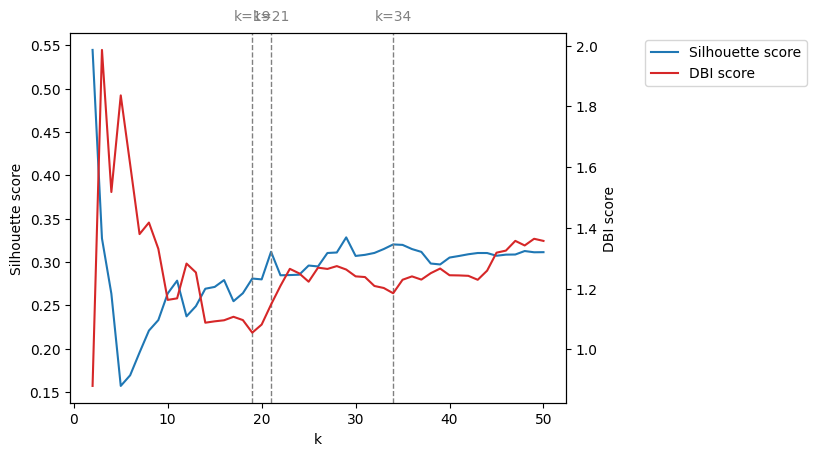

In [88]:
plotk(results_df, [19, 21, 34])

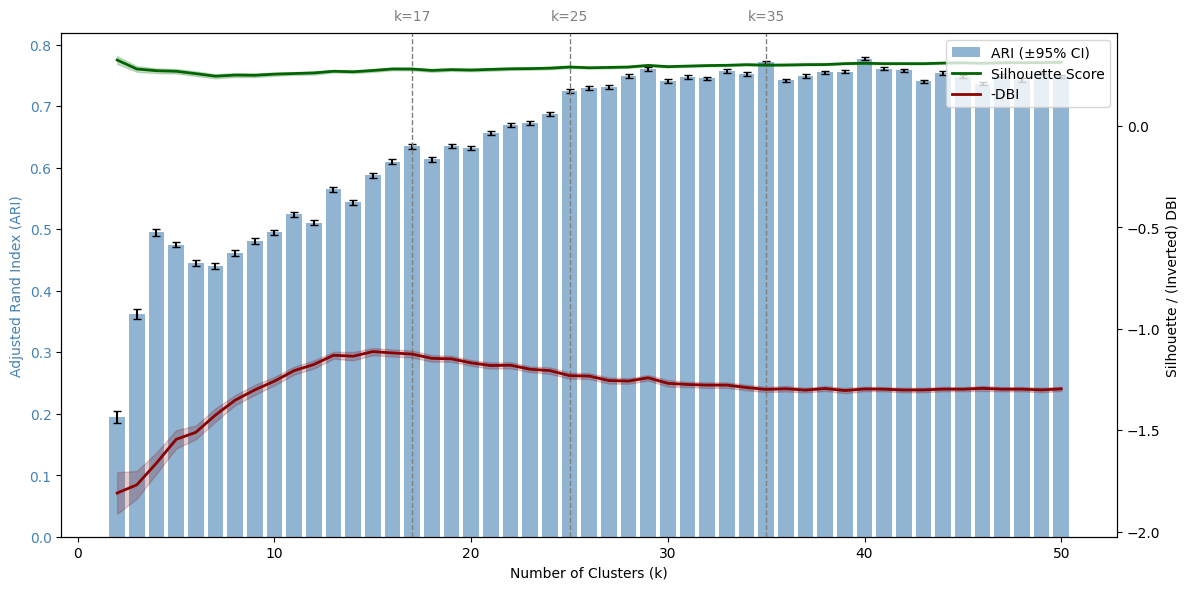

In [160]:
plot_clustering_metrics(metrics_df, vlines=[17,25, 35])

### K = 17

In [172]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 17)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/SPARC_KMeans_12F_17C_NOD_1_genepy.txt", sep='\t', index=False)

In [170]:
km_out_sparc.value_counts().sort_values(ascending=False)

Cluster
3          891
0          307
17         211
16         191
24         179
10         161
15          89
20          86
4           84
21          78
8           78
11          77
6           70
5           60
23          59
1           46
12          38
2           35
19          29
9           25
13          22
14          14
18          13
22           8
7            5
Name: count, dtype: int64

In [173]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(1.9656016595522573e-09), np.float64(2.9581740465241428e-09), np.float64(2.206302494137046e-06)]


### K = 25

In [174]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 25)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/SPARC_KMeans_12F_25C_NOD_1_genepy.txt", sep='\t', index=False)

### K = 35

In [191]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 35)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/SPARC_KMeans_12F_35C_NOD_1_genepy.txt", sep='\t', index=False)

In [193]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [236]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 26].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
312,ENSG00000132357_CARD6_CADD15_matrix,0.542133,26
313,ENSG00000167207_NOD2_CADD15_matrix,0.283975,26
314,ENSG00000112851_ERBIN_CADD15_matrix,0.066851,26
315,ENSG00000188130_MAPK12_CADD15_matrix,0.032015,26
316,ENSG00000135341_MAP3K7_CADD15_matrix,0.020104,26
317,ENSG00000137757_CASP5_CADD15_matrix,0.016271,26
318,ENSG00000110330_BIRC2_CADD15_matrix,0.014589,26
319,ENSG00000104312_RIPK2_CADD15_matrix,0.012920,26
320,ENSG00000103313_MEFV_CADD15_matrix,0.008147,26
321,ENSG00000156711_MAPK13_CADD15_matrix,0.002442,26


In [221]:
feat_imp_sparc[feat_imp_sparc['Feature'] == "ENSG00000112851_ERBIN_CADD15_matrix"].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
96,ENSG00000112851_ERBIN_CADD15_matrix,0.702498,8
324,ENSG00000112851_ERBIN_CADD15_matrix,0.530928,27
396,ENSG00000112851_ERBIN_CADD15_matrix,0.500188,33
253,ENSG00000112851_ERBIN_CADD15_matrix,0.302516,21
157,ENSG00000112851_ERBIN_CADD15_matrix,0.282857,13
229,ENSG00000112851_ERBIN_CADD15_matrix,0.208735,19
361,ENSG00000112851_ERBIN_CADD15_matrix,0.194263,30
265,ENSG00000112851_ERBIN_CADD15_matrix,0.192470,22
374,ENSG00000112851_ERBIN_CADD15_matrix,0.094255,31
86,ENSG00000112851_ERBIN_CADD15_matrix,0.093950,7


## 13 NOD Signalling Genes

In [75]:
#Check top 20 features with highest variance from consensus NOD signalling genes
#SPARC IBD
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 2)
sparc_ibd_NOD_sig20=X.var().sort_values(ascending=False)[0:20].index

#Soton IBD
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 2, "Soton")
soton_ibd_NOD_sig20=X.var().sort_values(ascending=False)[0:20].index

#MSCCR IBD
km_out_msccr_ibd, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes43, 2, "MSCCR")
msccr_ibd_NOD_sig20=X.var().sort_values(ascending=False)[0:20].index
intersection=set(sparc_ibd_NOD_sig20.str.split("_").str[0]) & set(soton_ibd_NOD_sig20.str.split("_").str[0]) & set(msccr_ibd_NOD_sig20.str.split(".").str[0])
NOD_sig_genes12=NOD_sig_genes43[NOD_sig_genes43['Gene stable ID'].isin(pd.DataFrame(intersection)[0])]
NOD_sig_genes12.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes12.txt", index=False, sep="\t")

In [155]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes12, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/SPARC_NODsig13_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
results_df

In [ ]:
metrics_df

In [ ]:
plotk(results_df, [15, 22, 26])

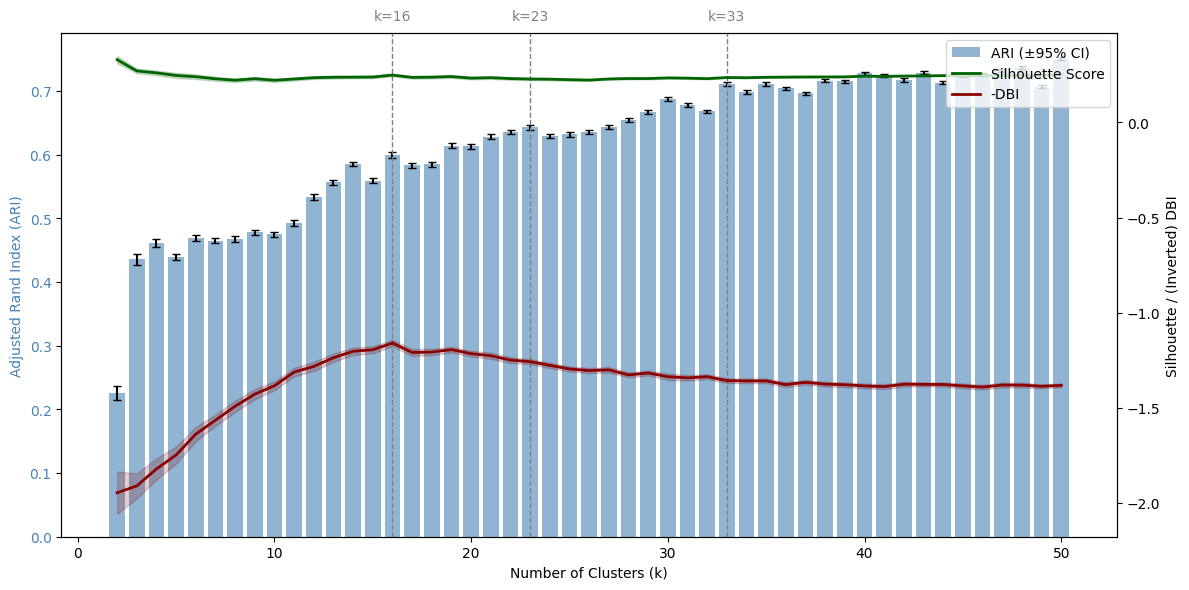

In [156]:
plot_clustering_metrics(metrics_df, vlines=[16, 23, 33])

### K = 16

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 16)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_13F_16C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 23

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 23)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 33

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes13, 33)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
#km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_13F_33C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_sparc.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_sparc = KM_RF(km_out_sparc, X)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Feature'] == "ENSG00000188130_MAPK12_CADD15_matrix"].sort_values("Importance", ascending=False)

In [ ]:
feat_imp_sparc[feat_imp_sparc['Cluster'] == 30].sort_values("Importance", ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_sparc, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

## 49 IL-10 Signalling Genes

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, "SPARC", n_iter=100)
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_IL10sig49_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
results_df

In [ ]:
metrics_df

In [ ]:
plotk(results_df, [5, 25, 37])

In [ ]:
plot_clustering_metrics(metrics_df, vlines=[25])

### K = 25

In [ ]:
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 20)
km_out_phen_GenePy_sparc = merge_phen_genepy(km_out_sparc, SPARC_IBD_CADD15_GenePy, X)
km_out_phen_GenePy_sparc.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_KMeans_47F_25C_IL10_1_genepy.txt", sep='\t', index=False)

## IL-10 Signalling Genes

In [ ]:
#Check top 20 features with highest variance from consensus IL-10 signalling genes
#SPARC IBD
km_out_sparc, X = KM(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_49, 2)
sparc_ibd_IL10_sig20=X.var().sort_values(ascending=False)[0:20].index

#Soton IBD
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 2, "Soton")
soton_ibd_IL10_sig20=X.var().sort_values(ascending=False)[0:20].index

intersection=set(sparc_ibd_IL10_sig20.str.split("_CADD15_matrix").str[0]) & set(soton_ibd_IL10_sig20)
IL10_sig_genes13=IL10_sig_genes_49[IL10_sig_genes_49['Gene stable ID'].isin(pd.DataFrame(intersection)[0].str.split("_").str[0])]
IL10_sig_genes13.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes13.txt", index=False, sep="\t")

In [29]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_13, 50, cohort_name='SPARC')
#Optimise k based on silhouette score, DBI, and ARI
metrics_df = compute_clustering_metrics(SPARC_IBD_CADD15_GenePy, IL10_sig_genes_13, 50, "SPARC", n_iter=100)
#metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_IL10sig49_clustering_metrics.txt")
metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_IL10sig13_clustering_metrics.txt", sep="\t", index=False)

In [30]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.414434,1.311451,2544
1,3,0.422511,1.109752,2522
2,4,0.210148,1.581256,1918
3,5,0.244043,1.313790,1830
4,6,0.221248,1.439680,973
5,7,0.227805,1.344132,957
6,8,0.256729,1.164058,904
7,9,0.272123,1.093421,879
8,10,0.279008,1.058220,866
9,11,0.296843,1.008331,866


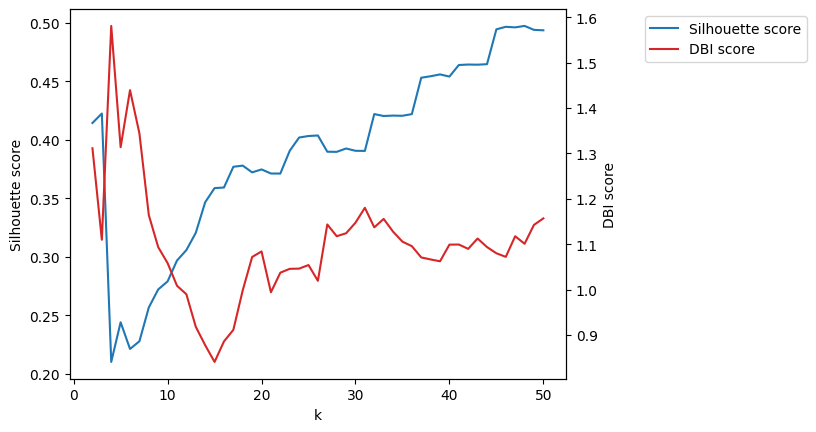

In [31]:
plotk(results_df)

In [32]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.162762,0.350790,0.009776,0.383516,0.132457,0.026415,1.575810,0.711369,0.141862
1,3,0.262656,0.310991,0.008667,0.298177,0.142962,0.028510,1.639535,0.558529,0.111383
2,4,0.335189,0.253230,0.007057,0.253482,0.117923,0.023516,1.639665,0.387060,0.077188
3,5,0.384594,0.224726,0.006263,0.251253,0.095892,0.019123,1.510143,0.302679,0.060361
4,6,0.426444,0.219113,0.006106,0.232370,0.065666,0.013095,1.453345,0.213000,0.042477
5,7,0.445706,0.219993,0.006131,0.239196,0.061487,0.012262,1.406896,0.208154,0.041510
6,8,0.550773,0.211565,0.005896,0.247421,0.028422,0.005668,1.280063,0.149116,0.029737
7,9,0.529004,0.203560,0.005673,0.255758,0.035448,0.007069,1.234461,0.147749,0.029464
8,10,0.580408,0.195138,0.005438,0.262041,0.024052,0.004796,1.179471,0.134956,0.026913
9,11,0.626556,0.186186,0.005189,0.272836,0.023042,0.004595,1.126840,0.136754,0.027272


KeyError: 'n_clusters'

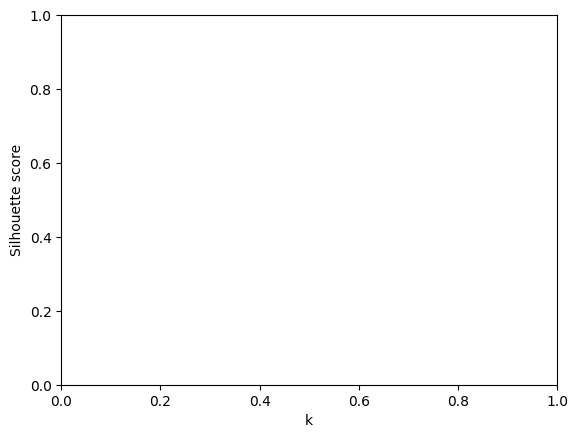

In [33]:
plotk(metrics_df)

## 34 Consensus IBD Genes

In [ ]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 50, cohort_name='SPARC')
metrics_df = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/SPARC_IBD_union34_clustering_metrics.txt")

In [ ]:
plotk(results_df, [28, 35, 40])

In [ ]:
# k = 40
km_out, X = KM(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 40)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 17].value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
km_out_phen_GenePy.value_counts('Crohn s disease phenotype', normalize=True)

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
#len(feat_imp[feat_imp['Importance'] >= 0.1]['Feature'].unique())
feat_imp[feat_imp['Cluster'] == 22]

In [ ]:
results_chi2 = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [ ]:
results_chi2['Diagnosis']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis']['residuals']

In [ ]:
results_chi2['Crohn s disease phenotype']['p_values_chi2']

In [ ]:
results_chi2['Crohn s disease phenotype']['residuals']

In [ ]:
results_chi2['IBD surgery final']['p_values_chi2']

In [ ]:
results_chi2['Diagnosis'].keys()

# Southampton IBD

## NOD2

In [ ]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='Soton')

In [ ]:
results_df

In [ ]:
plotk(results_df, [13, 20, 38])

In [ ]:
#k = 13
km_out, X = KM(SotonIBD_CADD15_GenePy, NOD2_gene, 13, "Soton")
km_out_phen_GenePy = merge_phen_genepy(km_out, SotonIBD_CADD15_GenePy, X, "Soton")

In [ ]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/Soton_KMeans_NOD2_13C_genepy.txt", sep='\t', index=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD phenotype', 'IBD Surgery', 'Granuloma'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['IBD phenotype']['overall_p_value'])
print(results_df['IBD Surgery']['overall_p_value'])
print(results_df['Granuloma']['overall_p_value'])

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] ==5 ]['ENSG00000167207.15_NOD2'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 5]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 12) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


## 9 NOD Signalling Genes

In [ ]:
#results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='Soton')
metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, "Soton", n_iter=100)

In [ ]:
metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig8_clustering_metrics.txt", sep="\t", index=False) #No IKBKG GenePy

In [ ]:
metrics_df

In [ ]:
#plotk(results_df,[21, 25, 32])
plot_clustering_metrics(metrics_df, vlines=[10, 16, 31])

### K = 10

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 10, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_10C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 16

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 16, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_16C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 31

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 31, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, "Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_8F_31C_NOD_2_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp = KM_RF(km_out, X)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery', 'Granuloma'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

In [ ]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp[feat_imp['Feature'] == "ENSG00000167207.15_NOD2"].sort_values(by="Importance", ascending=False)

In [ ]:
feat_imp[feat_imp['Cluster'] == 17].sort_values(by="Importance", ascending=False)

In [ ]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 9]['ENSG00000187796.16_CARD9'].value_counts()

In [ ]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 20]['Diagnosis'].value_counts()

In [ ]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 7) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


In [ ]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

In [ ]:
#Check raw and multiple-test-corrected p-values
results_df['Granuloma']['overall_p_value']#.keys()

## 43 NOD Signalling Genes

In [ ]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
#results_df
metrics_df

In [ ]:
plotk(results_df, [6, 24, 31])

In [ ]:
plot_clustering_metrics(metrics_df, vlines=[8, 16, 34])

### K = 8

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 8, "Soton") #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_8C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 16

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 16, "Soton") #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_16C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [ ]:
feat_imp_soton[feat_imp_soton['Feature'] == "ENSG00000185386_MAPK11"]

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 34

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 34, "Soton")  #39 genes; missing IL-18, NLRP7, NAIP, IKBKG
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv(
    "C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_39F_34C_NOD_1_genepy.txt",
    sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

## 12 NOD Signalling Genes

In [182]:
#results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/Soton_NODsig12_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [94]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.271482,1.660432,1047
1,3,0.318037,1.523208,1019
2,4,0.238043,1.607222,869
3,5,0.246209,1.527892,799
4,6,0.258150,1.381582,746
5,7,0.278291,1.245748,729
6,8,0.287254,1.180133,707
7,9,0.339057,1.024071,751
8,10,0.279154,1.124148,711
9,11,0.252081,1.142643,579


In [183]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.123272,0.293481,0.008179,0.331619,0.119918,0.023914,1.642559,0.542855,0.108257
1,3,0.317810,0.259919,0.007243,0.273532,0.070976,0.014154,1.657696,0.282304,0.056298
2,4,0.311875,0.217139,0.006051,0.252470,0.064773,0.012917,1.572778,0.250516,0.049958
3,5,0.325368,0.201909,0.005627,0.240870,0.051612,0.010293,1.462837,0.190228,0.037936
4,6,0.400217,0.205978,0.005740,0.240576,0.041420,0.008260,1.375679,0.170068,0.033915
5,7,0.427311,0.180256,0.005023,0.250033,0.036260,0.007231,1.296366,0.161133,0.032133
6,8,0.430370,0.169608,0.004727,0.252963,0.034568,0.006894,1.209228,0.117049,0.023342
7,9,0.435843,0.158659,0.004421,0.254888,0.033058,0.006592,1.162695,0.118173,0.023566
8,10,0.449519,0.150834,0.004203,0.262126,0.030613,0.006105,1.132554,0.100692,0.020080
9,11,0.464685,0.159380,0.004442,0.258379,0.025107,0.005007,1.112365,0.096898,0.019324


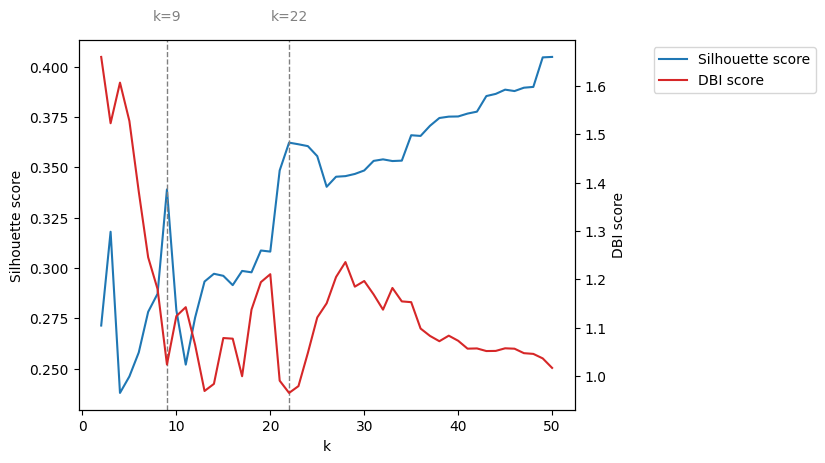

In [98]:
plotk(results_df, [9, 22])

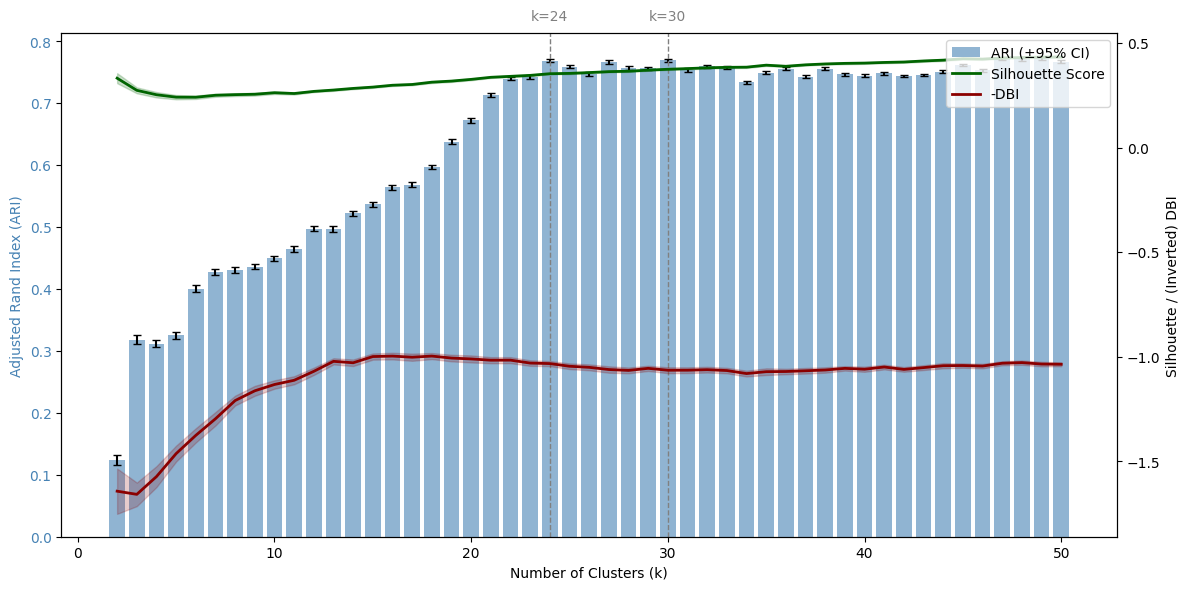

In [178]:
plot_clustering_metrics(metrics_df, vlines=[24, 30])

### K = 24

In [196]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 24, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/Soton_KMeans_12F_24C_NOD_1_genepy.txt", sep='\t', index=False)

In [188]:
km_out_soton.value_counts().sort_values(ascending=False)

Cluster
0          240
5          153
22          87
27          82
18          81
19          70
11          66
26          52
17          50
4           46
20          40
9           27
10          24
6           18
15          18
21          17
25          17
16          16
3           14
24          13
23          12
1           11
2           10
29           9
13           8
7            7
12           7
8            5
14           3
28           1
Name: count, dtype: int64

In [197]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [231]:
feat_imp_soton[feat_imp_soton['Cluster'] == 23].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
276,ENSG00000127837_AAMP,0.775078,23
277,ENSG00000103313_MEFV,0.050950,23
278,ENSG00000188130_MAPK12,0.049720,23
279,ENSG00000112851_ERBIN,0.042255,23
280,ENSG00000132357_CARD6,0.036580,23
281,ENSG00000167207_NOD2,0.019734,23
282,ENSG00000156711_MAPK13,0.014223,23
283,ENSG00000104312_RIPK2,0.010472,23
284,ENSG00000137757_CASP5,0.000446,23
285,ENSG00000110330_BIRC2,0.000442,23


In [199]:
feat_imp_soton[feat_imp_soton['Feature'] == "ENSG00000103313_MEFV"].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
192,ENSG00000103313_MEFV,0.868688,16
48,ENSG00000103313_MEFV,0.799965,4
169,ENSG00000103313_MEFV,0.101312,14
6,ENSG00000103313_MEFV,0.064810,0
230,ENSG00000103313_MEFV,0.054995,19
277,ENSG00000103313_MEFV,0.050950,23
65,ENSG00000103313_MEFV,0.044013,5
270,ENSG00000103313_MEFV,0.038218,22
121,ENSG00000103313_MEFV,0.026517,10
77,ENSG00000103313_MEFV,0.024775,6


In [189]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.008328581882796704), 1.0, np.float64(0.8134457411168908)]


### K = 30

In [187]:
### K = 24
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 30, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/Soton_KMeans_12F_30C_NOD_1_genepy.txt", sep='\t', index=False)

## 13 NOD Signalling Genes

In [180]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes12, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/Soton_NODsig13_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig12_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
results_df

In [ ]:
metrics_df

In [ ]:
plotk(results_df, [12, 23, 34, 38])

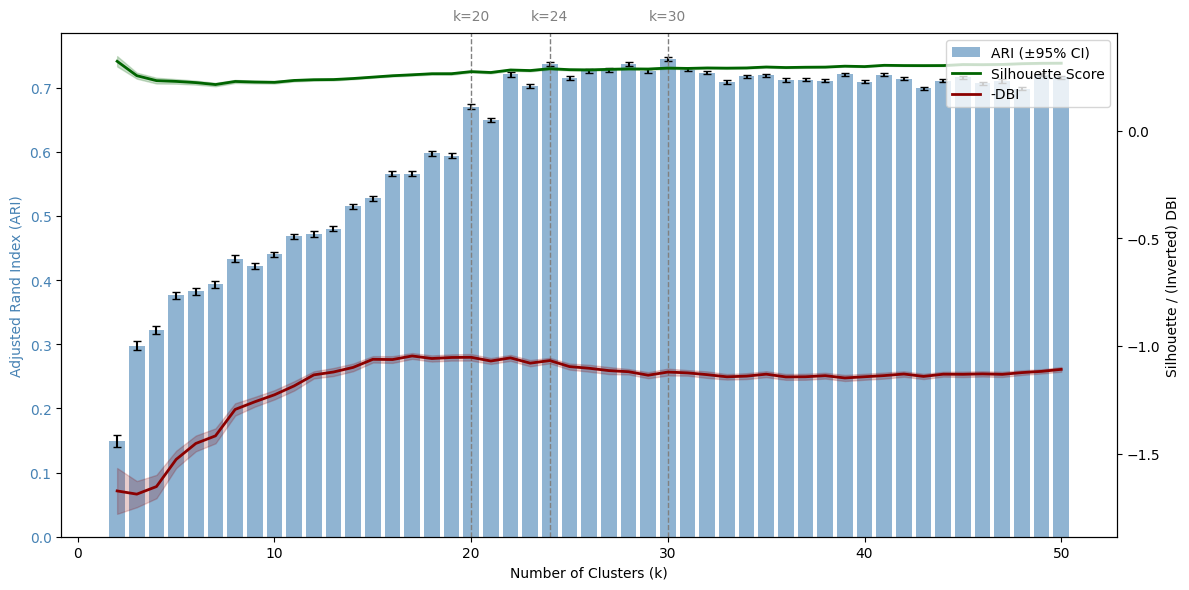

In [181]:
plot_clustering_metrics(metrics_df, vlines=[20, 24, 30])

### K = 20

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 20, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 24

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 24, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
#km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_13F_24C_NOD_1_genepy.txt", sep='\t', index=False)

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
feat_imp_soton = KM_RF(km_out_soton, X)

In [ ]:
feat_imp_soton[feat_imp_soton['Feature'] == "ENSG00000188130_MAPK12"].sort_values("Importance", ascending=False)

In [ ]:
feat_imp_soton[feat_imp_soton['Cluster'] == 2].sort_values("Importance", ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

### K = 30

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes13, 30, "Soton")
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")

In [ ]:
km_out_soton.value_counts().sort_values(ascending=False)

In [ ]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_soton, ['Diagnosis', 'IBD.phenotype', 'IBD.Surgery'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

## 49 IL-10 Signalling Genes

In [ ]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 50, cohort_name='Soton')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(SotonIBD_CADD15_GenePy, NOD_sig_genes43, 50, "Soton", n_iter=100)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_IL10sig49_clustering_metrics.txt")
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_NODsig43_clustering_metrics.txt", sep="\t", index=False)

In [ ]:
results_df

In [ ]:
metrics_df

In [ ]:
plotk(results_df, [6, 35])

In [ ]:
plot_clustering_metrics(metrics_df, vlines=[17, 29, 36])

### K = 29

In [ ]:
km_out_soton, X = KM(SotonIBD_CADD15_GenePy, IL10_sig_genes_49, 29, "Soton") #42 genes
km_out_phen_GenePy_soton = merge_phen_genepy(km_out_soton, SotonIBD_CADD15_GenePy, X, cohort_name="Soton")
km_out_phen_GenePy_soton.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Soton_KMeans_42F_29C_IL10_1_genepy.txt", sep='\t', index=False)

# Mt Sinai IBD + Controls

## 9 NOD Signalling Genes

In [14]:
#Optimise k based on silhouette score and DBI
#results_df = KM_opt(MSCCR_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='MSCCR')
#Optimise k based on silhouette score, DBI, and ARI
metrics_df = compute_clustering_metrics(MSCCR_CADD15_GenePy, NOD_sig_genes9, 50, "MSCCR", n_iter=100)
metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/MSCCR_NODsig9_clustering_metrics.txt", sep="\t", index=False)
#metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", index_col=None)

In [11]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.513089,0.914986,1161
1,3,0.515550,1.065208,1106
2,4,0.510091,0.882447,1094
3,5,0.521515,0.819263,1079
4,6,0.420019,0.942246,901
5,7,0.457869,0.844923,873
6,8,0.557627,0.759048,960
7,9,0.472375,0.802572,888
8,10,0.334823,0.968660,666
9,11,0.340774,0.915482,665


In [15]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.347663,0.419992,0.011704,0.515510,0.080279,0.016009,1.026423,0.314030,0.062624
1,3,0.619709,0.241062,0.006718,0.457834,0.082195,0.016392,1.091357,0.300360,0.059898
2,4,0.641778,0.195955,0.005461,0.452972,0.067625,0.013486,1.025340,0.227554,0.045379
3,5,0.648918,0.168387,0.004692,0.460626,0.071201,0.014199,0.987342,0.205775,0.041036
4,6,0.690575,0.154570,0.004307,0.468909,0.056444,0.011256,0.908106,0.153580,0.030627
5,7,0.661768,0.188039,0.005240,0.435939,0.086383,0.017227,0.905838,0.153980,0.030707
6,8,0.761416,0.159783,0.004453,0.466640,0.058600,0.011686,0.820330,0.108931,0.021723
7,9,0.738326,0.172851,0.004817,0.457694,0.070029,0.013965,0.816944,0.108388,0.021615
8,10,0.697622,0.183516,0.005114,0.449171,0.078019,0.015559,0.815795,0.101023,0.020146
9,11,0.733608,0.184967,0.005155,0.460644,0.076060,0.015168,0.805579,0.090676,0.018083


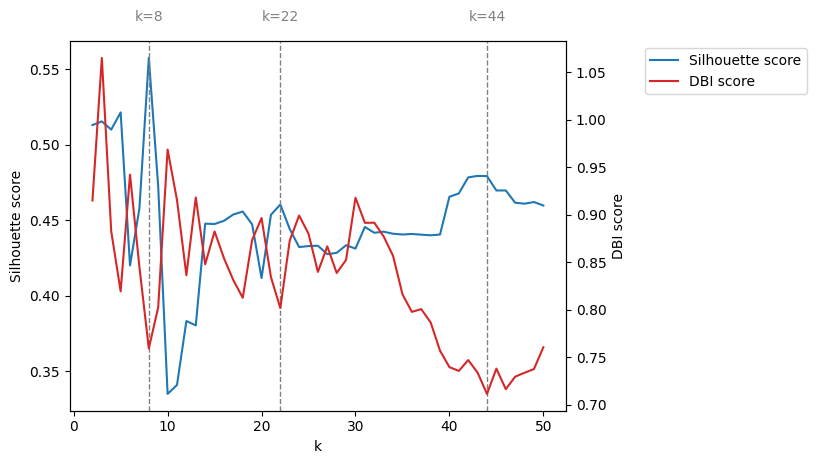

In [13]:
plotk(results_df, [8, 22, 44])

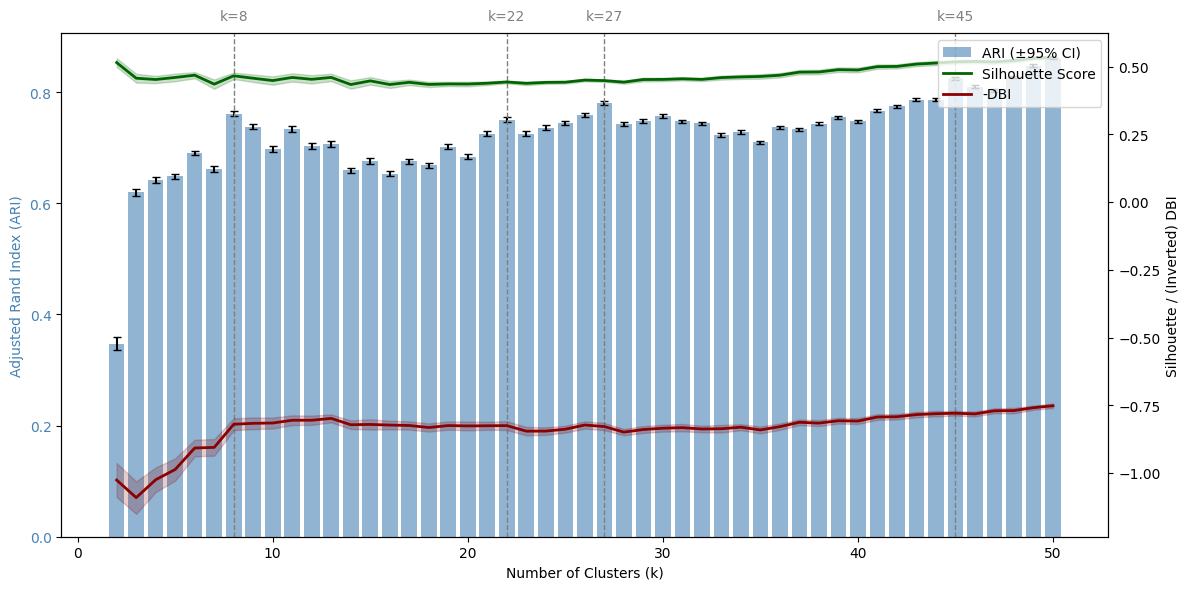

In [18]:
plot_clustering_metrics(metrics_df, vlines=[8, 22, 27, 45])

### K = 27

In [7]:
km_out_msccr, X = KM(MSCCR_CADD15_GenePy, NOD_sig_genes9, 27, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_CADD15_GenePy, X, "MSCCR")
km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_KMeans_9F_27C_NOD_2_genepy.txt", sep='\t', index=False)

## NOD Signalling Genes

In [ ]:
#Check top 15 features with highest variance from consensus NOD signalling genes

# Mt Sinai IBD Only

## 9 NOD Signalling Genes

In [12]:
## 9 NOD Signalling Genes
#Optimise k based on silhouette score and DBI
results_df = KM_opt(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='MSCCR')
#Optimise k based on silhouette score, DBI, and ARI
metrics_df = compute_clustering_metrics(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes9, 50, "MSCCR", n_iter=100)
metrics_df.to_csv(
    "C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/MSCCR_IBD_NODsig9_clustering_metrics.txt",
    sep="\t", index=False)
#metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/SPARC_NODsig9_clustering_metrics.txt", index_col=None)

In [13]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.514077,0.887785,891
1,3,0.355537,1.285124,735
2,4,0.368568,1.068906,727
3,5,0.403786,0.931121,708
4,6,0.427982,1.127541,628
5,7,0.462362,0.844976,611
6,8,0.354954,1.068078,495
7,9,0.352804,0.907956,494
8,10,0.349945,0.881622,494
9,11,0.378140,0.808886,476


In [14]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.307900,0.408912,0.011395,0.545971,0.087796,0.017508,0.910202,0.190859,0.038061
1,3,0.652131,0.237085,0.006607,0.475349,0.059818,0.011929,0.988616,0.267719,0.053389
2,4,0.678118,0.172925,0.004819,0.455658,0.061003,0.012165,0.973586,0.217956,0.043465
3,5,0.680833,0.181823,0.005067,0.457174,0.065115,0.012985,0.898505,0.185272,0.036947
4,6,0.654186,0.192760,0.005372,0.442224,0.082941,0.016540,0.907248,0.203152,0.040513
5,7,0.729000,0.170099,0.004740,0.448610,0.064575,0.012878,0.865539,0.141830,0.028284
6,8,0.715934,0.181818,0.005067,0.442918,0.067322,0.013426,0.846320,0.141219,0.028162
7,9,0.704617,0.178678,0.004979,0.448765,0.075537,0.015064,0.812335,0.118809,0.023693
8,10,0.676716,0.182074,0.005074,0.440724,0.082394,0.016431,0.811933,0.107615,0.021461
9,11,0.719152,0.170335,0.004747,0.462744,0.066703,0.013302,0.786435,0.106604,0.021259


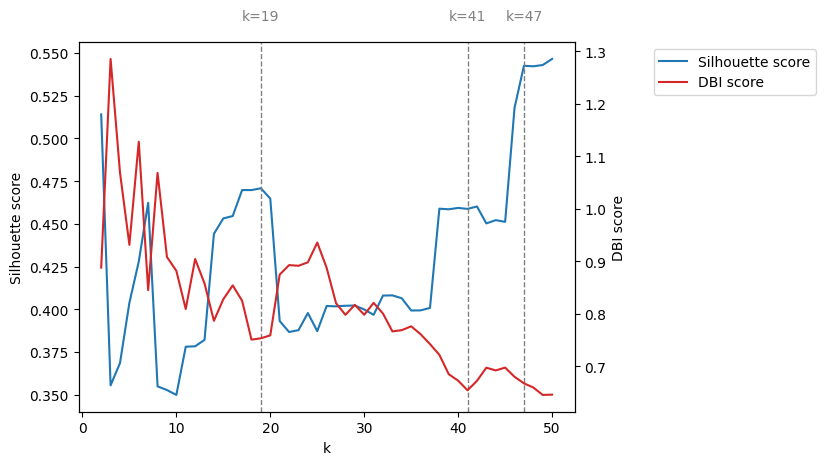

In [21]:
plotk(results_df, [19, 41, 47])

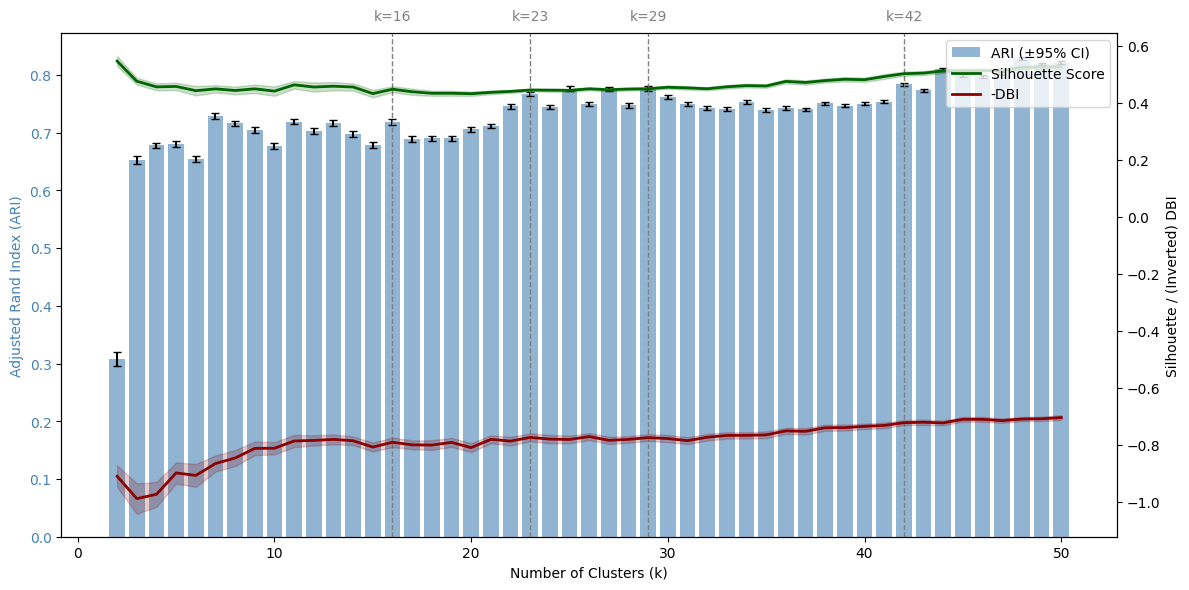

In [28]:
plot_clustering_metrics(metrics_df, vlines = [16, 23, 29, 42])

In [55]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes9, 42, "MSCCR")
km_out_msccr.value_counts().sort_values(ascending=False)

Cluster
5          182
16         126
37         113
0          113
2           89
24          56
34          48
30          42
19          41
1           34
9           24
25          21
15          19
11          18
41          17
8           11
6           10
3            9
21           9
10           9
29           8
20           6
31           6
7            4
14           4
23           4
28           3
4            2
39           2
33           2
12           2
36           2
13           1
17           1
22           1
18           1
27           1
26           1
32           1
35           1
38           1
40           1
Name: count, dtype: int64

### K = 23

In [56]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes9, 23, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_9F_23C_NOD_2_genepy.txt", sep='\t', index=False)

In [57]:
feat_imp_msccr = KM_RF(km_out_msccr, X)

In [59]:
feat_imp_msccr[feat_imp_msccr['Cluster'] == 7]

,Feature,Importance,Cluster
63,ENSG00000213341.11_CHUK,5.959339e-01,7
64,ENSG00000167207.15_NOD2,2.380653e-01,7
65,ENSG00000104312.8_RIPK2,9.420459e-02,7
66,ENSG00000106100.11_NOD1,3.858012e-02,7
67,ENSG00000064012.24_CASP8,3.292547e-02,7
68,ENSG00000187796.16_CARD9,2.592627e-04,7
69,ENSG00000104365.16_IKBKB,3.103314e-05,7
70,ENSG00000269335.7_IKBKG,3.171717e-07,7
71,ENSG00000137752.25_CASP1,0.000000e+00,7


## 12 NOD Signalling Genes

In [118]:
#Optimise k based on silhouette score and DBI
results_df = KM_opt(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes12, 50, cohort_name='MSCCR')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes12, 50, "MSCCR", n_iter=100)
#metrics_df.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/MSCCR_IBD_NODsig12_clustering_metrics.txt", sep="\t", index=False)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Clustering metrics/MSCCR_IBD_NODsig12_clustering_metrics.txt", index_col=None)

In [105]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.531586,0.808630,1003
1,3,0.274869,1.391584,756
2,4,0.298403,1.348491,749
3,5,0.316002,1.229065,728
4,6,0.361630,1.394360,751
5,7,0.351333,1.036142,733
6,8,0.329620,1.264765,558
7,9,0.344279,1.233198,536
8,10,0.354645,0.996596,537
9,11,0.364524,0.952093,532


In [107]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.146454,0.331265,0.009231,0.353478,0.129086,0.025742,1.478215,0.500935,0.099897
1,3,0.339222,0.308058,0.008585,0.286965,0.079752,0.015904,1.472099,0.324941,0.064800
2,4,0.444319,0.243624,0.006789,0.277494,0.050259,0.010023,1.412924,0.234136,0.046692
3,5,0.479818,0.198767,0.005539,0.283117,0.039871,0.007951,1.348926,0.213376,0.042552
4,6,0.529132,0.180056,0.005018,0.289384,0.036576,0.007294,1.295536,0.201612,0.040206
5,7,0.527107,0.151621,0.004225,0.294448,0.039875,0.007952,1.291390,0.181954,0.036286
6,8,0.545280,0.145210,0.004047,0.292797,0.043456,0.008666,1.258073,0.173138,0.034527
7,9,0.531845,0.145080,0.004043,0.296073,0.039234,0.007824,1.202410,0.148112,0.029537
8,10,0.555197,0.144270,0.004020,0.291804,0.043614,0.008697,1.206620,0.150430,0.029999
9,11,0.575319,0.150694,0.004199,0.293895,0.043061,0.008587,1.134214,0.124942,0.024916


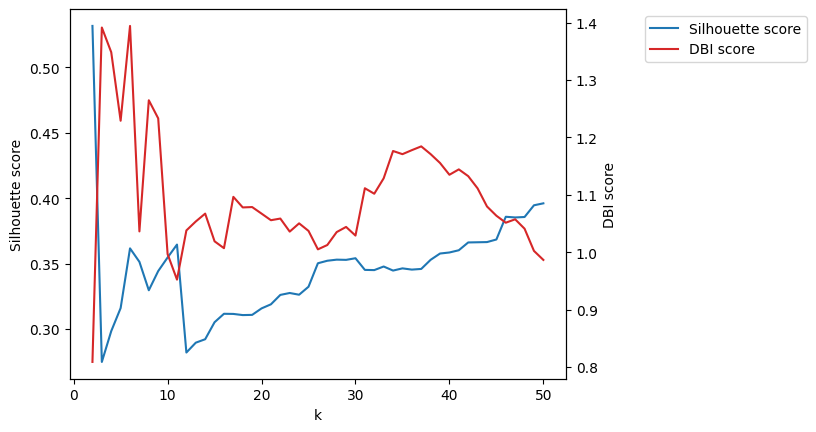

In [108]:
plotk(results_df)

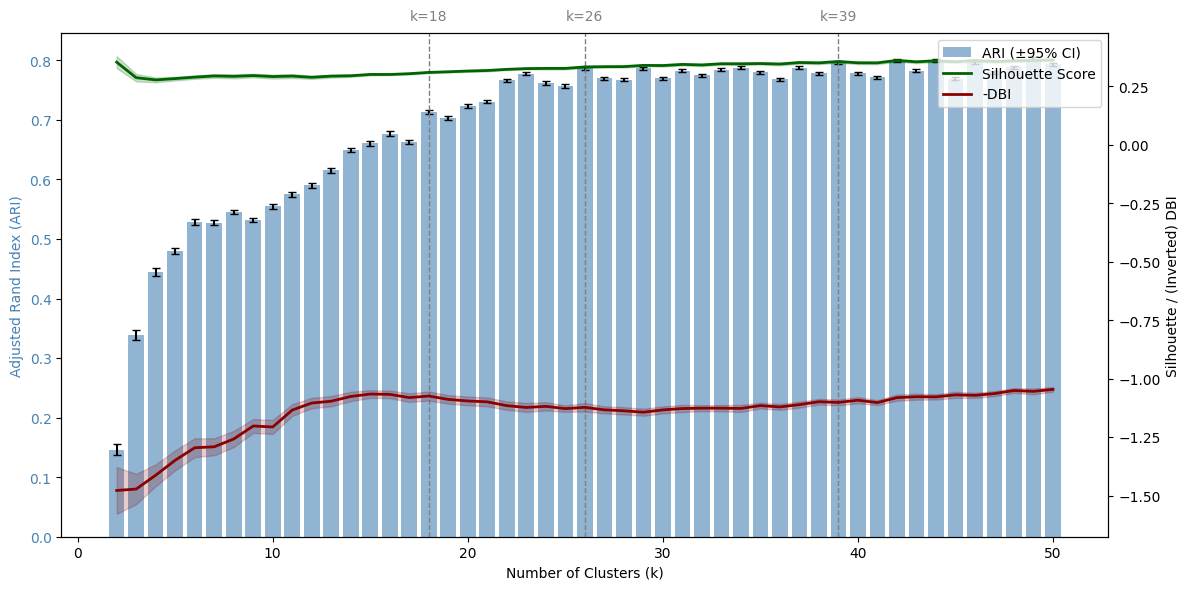

In [119]:
plot_clustering_metrics(metrics_df, vlines=[18, 26, 39])

### K = 18

In [125]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes12, 18, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
#km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_12F_18C_NOD_1_genepy.txt", sep='\t', index=False)

In [129]:
km_out_msccr.value_counts().sort_values(ascending=False)

Cluster
0          256
15         100
7           76
16          65
32          54
38          43
13          41
26          40
20          34
34          33
10          28
33          27
6           27
1           22
24          16
37          16
8           15
4           15
30          14
21          14
11          12
17          12
12          11
36          10
2            9
14           7
5            7
18           6
35           6
25           5
3            4
9            4
28           4
23           3
19           3
22           2
29           2
31           2
27           1
Name: count, dtype: int64

In [130]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_msccr, ['IBD_diagnosis', "CD_behaviour", 'Number_of_IBD_surgeries'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.0045812759041268395), np.float64(0.2997646805024259), np.float64(2.9957959429200964e-06)]


### K = 26

In [200]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes12, 26, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
#km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_12F_26C_NOD_1_genepy.txt", sep='\t', index=False)

In [201]:
feat_imp_msccr = KM_RF(km_out_msccr, X)

In [134]:
feat_imp_msccr[feat_imp_msccr['Feature'] == "ENSG00000103313.14_MEFV"].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
288,ENSG00000103313.14_MEFV,0.746832,24
204,ENSG00000103313.14_MEFV,0.683525,17
264,ENSG00000103313.14_MEFV,0.485923,22
48,ENSG00000103313.14_MEFV,0.369138,4
3,ENSG00000103313.14_MEFV,0.099198,0
39,ENSG00000103313.14_MEFV,0.070191,3
183,ENSG00000103313.14_MEFV,0.063004,15
85,ENSG00000103313.14_MEFV,0.053987,7
198,ENSG00000103313.14_MEFV,0.040327,16
136,ENSG00000103313.14_MEFV,0.038832,11


In [233]:
feat_imp_msccr[feat_imp_msccr['Cluster'] == 14].sort_values("Importance", ascending=False)

,Feature,Importance,Cluster
168,ENSG00000127837.10_AAMP,0.712104,14
169,ENSG00000112851.16_ERBIN,0.071787,14
170,ENSG00000110330.10_BIRC2,0.046272,14
171,ENSG00000188130.14_MAPK12,0.046151,14
172,ENSG00000104312.8_RIPK2,0.040865,14
173,ENSG00000103313.14_MEFV,0.023300,14
174,ENSG00000167207.15_NOD2,0.022354,14
175,ENSG00000135341.19_MAP3K7,0.019427,14
176,ENSG00000132357.14_CARD6,0.008953,14
177,ENSG00000173039.20_RELA,0.008455,14


### K = 39

In [176]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes12, 39, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_12F_39C_NOD_1_genepy.txt", sep='\t', index=False)

## 15 NOD Signalling Genes

In [19]:
#Check top 15 features with highest variance from consensus NOD signalling genes
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes43, 2, "MSCCR")
msccr_ibd_NOD_sig15=X.var().sort_values(ascending=False)[0:15].index
NOD_sig_genes15_msccr=NOD_sig_genes43[NOD_sig_genes43['Gene stable ID'].isin(pd.DataFrame(msccr_ibd_NOD_sig15)[0].str.split(".").str[0])]
NOD_sig_genes15_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes15_MSCCR.txt", index=False, sep="\t")

In [34]:
#Optimise k based on silhouette score and DBI
results_df = KM_opt(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes15_msccr, 50, cohort_name='MSCCR')
#Optimise k based on silhouette score, DBI, and ARI
#metrics_df = compute_clustering_metrics(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes15_msccr, 50, "MSCCR", n_iter=100)
#metrics_df.to_csv(
#    "C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/MSCCR_IBD_NODsig15_clustering_metrics.txt",
#    sep="\t", index=False)
metrics_df=pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/MSCCR_IBD_NODsig15_clustering_metrics.txt", index_col=None)

In [35]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.383698,1.265694,1006
1,3,0.205101,1.745584,772
2,4,0.217563,1.514252,745
3,5,0.237657,1.420603,701
4,6,0.249736,1.345774,686
5,7,0.333830,1.124970,724
6,8,0.191331,1.316200,550
7,9,0.219079,1.233854,516
8,10,0.236415,1.171450,498
9,11,0.254085,1.129648,418


In [36]:
metrics_df

,k,mean_ari,std_ari,ci_ari,mean_silhouette,std_silhouette,ci_silhouette,mean_dbi,std_dbi,ci_dbi
0,2,0.132413,0.322660,0.008992,0.349212,0.116437,0.023220,1.523645,0.524705,0.104637
1,3,0.245991,0.294486,0.008207,0.273015,0.084267,0.016805,1.616558,0.360177,0.071827
2,4,0.333141,0.254339,0.007088,0.253800,0.067515,0.013464,1.576014,0.262217,0.052292
3,5,0.427303,0.218104,0.006078,0.239272,0.043809,0.008736,1.527001,0.233382,0.046541
4,6,0.409638,0.186566,0.005199,0.245535,0.049090,0.009790,1.464640,0.204233,0.040728
5,7,0.433739,0.170883,0.004762,0.246457,0.039642,0.007905,1.411775,0.175958,0.035090
6,8,0.494805,0.148300,0.004133,0.254308,0.038203,0.007619,1.352233,0.191010,0.038091
7,9,0.525367,0.149870,0.004176,0.264606,0.035165,0.007013,1.314221,0.178314,0.035560
8,10,0.534836,0.142457,0.003970,0.271881,0.034165,0.006813,1.253837,0.162989,0.032503
9,11,0.535813,0.140261,0.003909,0.270018,0.037006,0.007380,1.227833,0.132673,0.026458


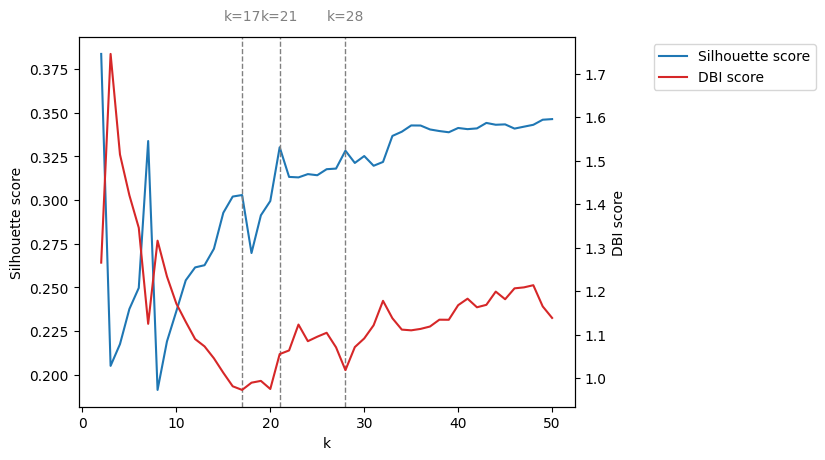

In [42]:
plotk(results_df, [17, 21, 28])

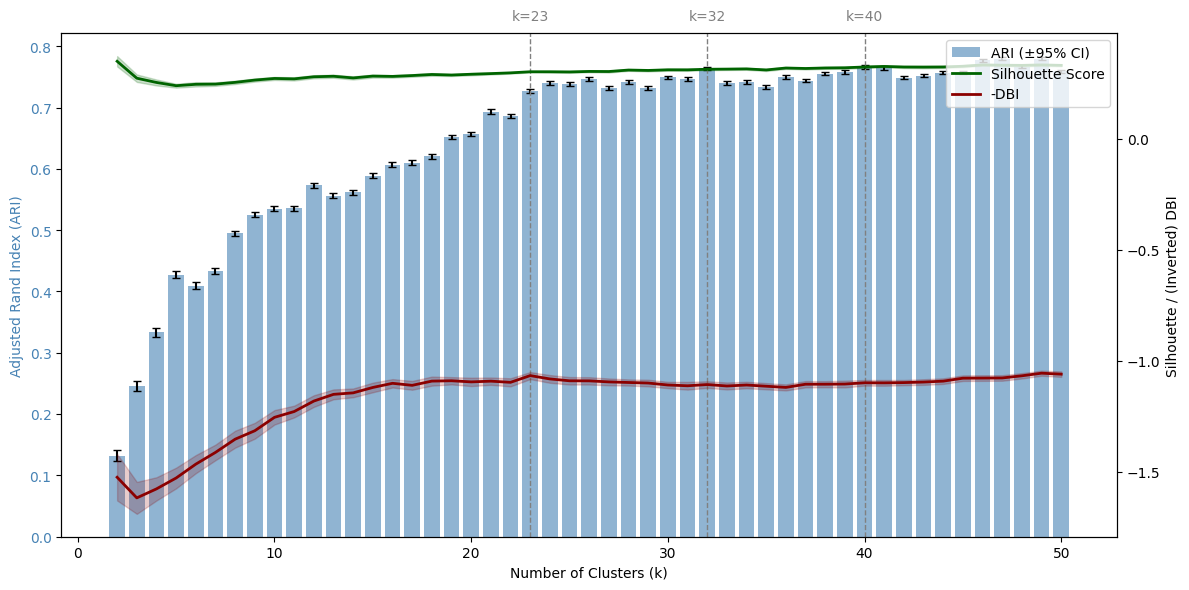

In [43]:
plot_clustering_metrics(metrics_df, vlines=[23, 32, 40])

### K = 23

In [50]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes15_msccr, 23, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_15F_23C_NOD_2_genepy.txt", sep='\t', index=False)

### K = 32

In [44]:
km_out_msccr, X = KM(MSCCR_IBD_CADD15_GenePy, NOD_sig_genes15_msccr, 32, "MSCCR")
km_out_phen_GenePy_msccr = merge_phen_genepy(km_out_msccr, MSCCR_IBD_CADD15_GenePy, X, "MSCCR")
km_out_phen_GenePy_msccr.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means Paper/Results/MSCCR_IBD_KMeans_15F_32C_NOD_2_genepy.txt", sep='\t', index=False)

In [46]:
feat_imp_msccr = KM_RF(km_out_msccr, X)

In [49]:
feat_imp_msccr[(feat_imp_msccr['Importance'] <= 0.5) & (feat_imp_msccr['Importance'] >= 0.1)]

,Feature,Importance,Cluster
0,ENSG00000196954.14_CASP4,0.375932,0
1,ENSG00000103490.14_PYCARD,0.331315,0
2,ENSG00000188130.14_MAPK12,0.128541,0
15,ENSG00000132357.14_CARD6,0.191227,1
16,ENSG00000167207.15_NOD2,0.176785,1
17,ENSG00000110330.10_BIRC2,0.103098,1
60,ENSG00000103490.14_PYCARD,0.382061,4
61,ENSG00000167207.15_NOD2,0.363126,4
90,ENSG00000196954.14_CASP4,0.410440,6
91,ENSG00000167207.15_NOD2,0.275367,6


In [45]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy_msccr, ['IBD_diagnosis', "CD_behaviour", 'Number_of_IBD_surgeries'])
values = [subdict['overall_p_value'] for subdict in list(results_df.values())[:3]]
print(values)

[np.float64(0.0038250664246745275), np.float64(0.3860157520051024), np.float64(0.00014282847236382675)]
